## Distribuição Territorial de Postos de Trabalho

**AUTORIA:** [REDE MOB](https://www.redemob.com.br/), com proximento metodológico inspirado e derivado do projeto [Acesso a Oportunidades](https://github.com/ipeaGIT/acesso_oport).

Este script faz a leitura e consolidação de dados de estabelecimentos de varejo ou serviços e dos respectivos postos de trabalho. A maior parte dos dados deriva da Relação Anual de Informações Sociais (RAIS), com complementos derivados do Cadastro Nacional dos Estabelecimentos de Saúde (CNES) e do Censo Escolar, para prover, respectivamente, informaçõs a respeito de serviços de saúde e de escolas sob a égide do setor público

**PANORAMA:**
- Faz a leitura dos dados — RAIS, CNES e Censo Escolar — com a API da Base dos Dados
- Quando os dados acima não possuem informações geográficas — latitude e longitude —, faz a geolocalização dos endereços a partir:
    - Da biblioteca [geobr](https://github.com/ipeaGIT/geobr); e
    - Do Cadastro Nacional de Endereços para Fins Estatísticos ([CNEFE](https://basedosdados.org/dataset/33b49786-fb5f-496f-bb7c-9811c985af8e?table=566ed7f2-db5f-4ac3-bfce-b579137c993c).
- Diferencia os posto de trabalho com o setor de atividade economica, tomando como base o [CONCLA](https://cnae.ibge.gov.br/?view=estrutura)
- Produz mapas e gráficos descritivos.


**MAIS INFORMAÇÕES:**
- [Layout da Plataforma]
- [Sumário dos Dados Disponíveis]
- *Lorem ipsum: Conteúdo do MOB de interesse, técnico ou de divulgação*

**LINKS DE INTERESSE:**
- links para materiais técnicos e acadêmicos gerais, externos, de referência a respeito do conteúdo abordado


# Instruções

Este script requer:
1. O código do IBGE para o município
    - Caso se deseje fazer a análise de municípios vizinhos, fornecer uma lista com os códigos do IBGE destes municípios
  
2. [Chave referente a um projeto no Google Cloud](https://basedosdados.org/docs/access_data_bq)

# Parâmetros Definidos Pelo Usuário

In [31]:
# Backend preliminar
from getpass import getpass

In [32]:
# Forneça código do IBGE da cidade, ou lista de códigos
# se quiser cidades vizinhas. P. ex.:
# ibge_id = 3303302 -> Niterói
ibge_id = [3303302, 3304904, 3301900] # Niterói, São Gonçalo, Itaboraí

# Chave de API do Google Cloud Platform
gcloud_id = getpass("Chave de API do Google Cloud Platform: ")
    

# Backend

## Set Up Inicial

In [33]:
import pathlib
import re
from string import ascii_uppercase

import basedosdados as bd
import geobr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tobler.util import h3fy

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('Solarize_Light2')

In [35]:
pd.options.display.float_format = '{:,.2f}'.format

# Das Malhas Territorias

A malha hexagonal H3 será utilizada como recorte espacial principal ao longo das análises†. Recortes hexagonais apresentam vantagens importantes frente a outras geometrias, sobretudo, eles podem reduzir vieses amostrais derivados de efeitos de borda e, adicionalmente, são mais mais adequados do que malhas retangulares para analisar fenômenos em que relações de vizinhança e conectividade são importantes (Birch, Oom, & Beecham, 2007). Essas vantagens da malha hexagonal serão mais imporantes quando estiverem sendo executadas as análises de acessibilidade, mas, até lá, também foi mostrado por Birch et al. (2007) que hexágonos favorecem a visualização de padrões e mitigam, em alguma medida, efeitos de borda.

Esses efeitos de borda, simplificadamente, dizem respeito a erros de representação na variação local dos dados. Isto é, outras geometrias — malhas quadriculadas, p. ex. — são mais propensas a apresentar variações bruscas e artificiais entre vizinhos — uma quadrícula com valores muito altos ladeada por quadrículas com valores muito baixos. Isso prejudica a análise e a visualização, assim favorecendo erros de interpretação.

Dados socioeconômicos e demográficos, por sua vez, serão imputados em cada hexágono a partir do enso demográfico de 2010. Esses dados censitários serão requisitados ao datalake público da Base dos Dados‡, enquanto que as malhas desses setores serão obtidas junto à biblioteca geobr⨥. Assim, de posse das malhas do IBGE e dos respectivos dados, procedimentos de interpolação espacial⁙ farão a transferência dos dados do censo para os hexágonos.

Complementarmente, para além das informações dos setores censitários, a grade estatística⁜ também será utilizada como insumo, a qual apresenta contagens populacionais com uma resolução maior que a dos agregados por setor: há uma malha com resolução de 200x200 m em áreas urbanas e de 1x1 km em áreas rurais. A grade é importante porque remove as áreas inabitadas — a Floresta d Tijuca, no Rio de Janeiro, p. ex. — e porque permitem localizar o centroide dos hexágonos de maneira mais precisa: seguindo recomendação de Stępniak and Jacobs-Crisioni (2017), o centro de cada geometria deve ser ponderado pela distribuição populacional nela contida, a fim de que haja uma representação mais precisa dos tempos de viagem entre geometrias.

Resta definir qual a resolução dessas malha. Conforme demonstrado, por exemplo, em Pereira et al. (2019), é importante avaliar distintos tamanhos de geometria, a fim de verificar se os resultados obtidos são realmente robustos ou se não passam de artefatos computacionais. Mas, quais resoluções⁕? A menor escala na qual ainda há dados disponíveis é a grade estatística, de maneira que hexágonos menores que ela não agregariam nenhum valor à análise, ao mesmo tempo em que elevariam, desnecessariamente, o tempo de processamento computacional. Com efeito, a menor resolução utilizada é a 9, com área relativamente próxima a um quadrado de lado 200m. No outro extremo, resta definir a maior resolução utilizada. A maior delas será a 7, com área de aproximadamente 5 km2. Tamahos maiores agregariam grandes regiões muito distintas entre si, contribuindo em demasiado para uma ilusão de homogeneidade a qual não existe — p. ex., a resolução 6 já conta com área de cercade 35km2. Portanto, serão avaliadas as resoluções 7, 8 e 9.

    Birch, C. P., Oom, S. P., & Beecham, J. A. (2007). Rectangular and hexagonal grids used for observation, experiment and simulation in ecology. Ecological modelling, 206(3-4), 347-359.
    
    Pereira, R. H., Banister, D., Schwanen, T., & Wessel, N. (2019). Distributional effects of transport policies on inequalities in access to opportunities in Rio de Janeiro. Journal of Transport and Land Use, 12(1), 741-764.
    
    Stępniak, M., & Jacobs-Crisioni, C. (2017). Reducing the uncertainty induced by spatial aggregation in accessibility and spatial interaction applications. Journal of Transport Geography, 61, 17-29.

    † Especificamente, será feito uso das bibliotecas em Python implementadas pela Uber (https://h3geo.org/), baseadas no sistema proposto em:

        Sahr, K., White, D., & Kimerling, A. J. (2003). Geodesic discrete global grid systems. Cartography and Geographic Information Science, 30(2), 121-134.
        
    ‡ ver https://basedosdados.org/

    ⨥ ver https://github.com/ipeaGIT/geobr
    
    ⁙ https://github.com/pysal/tobler

    ⁜ obtida diretamente do site do IBGE em https://censo2010.ibge.gov.br/component/saladeimprensa/?busca=1&id=3&idnoticia=3123&t=grade-estatistica-permite-obter-dados-censo-2010-diversos-recortes-espaciais&view=noticia
    
    ⁕ ver https://h3geo.org/docs/core-library/restable para uma lista de resoluções e as respectivas dimensões

## Área de Estudo

In [36]:
def get_study_area(ibge_id):
    if not isinstance(ibge_id, list):
        ibge_id = [ibge_id]

    return pd.concat([
        geobr.read_census_tract(id_)
        for id_
        in ibge_id
        ]).astype({'code_muni': int})


tracts = get_study_area(ibge_id)

In [37]:
crs = tracts.estimate_utm_crs(datum_name='SIRGAS 2000')
crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [38]:
tracts = tracts.to_crs(crs)

Abaixo, utiliza-se a função h3fy, cuja documentação pode ser encontrada [aqui](https://pysal.org/tobler/generated/tobler.util.h3fy.html). A ideia é encontrar a malha hexagonal referente à área de estudo — os municípios cujo código está na variável `ibge_id`, acima.

In [39]:
hexes = h3fy(tracts, resolution=9)

# Relação Anual de Informações Sociais (RAIS)

A Relação Anual de Informações Sociais (RAIS), do Ministério do Trabalho e Emprego, é uma bas de dados que contém os quantitativos de empregos por estabelecimento, os quais ainda são geolocalizados por CEP. Dessa forma, é possível evidenciar a concentração de empresas e serviços no interior de cada hexágono H3 no interior da área de estudo. Com efeito, é a partir da RAIS que será consolidada a variável dependente do modelo.

Uma limitação dos dados da RAIS é que eles apenas contemplam os empregos formais, assim sub-representando a economia subterrânea, a informalidade. Contudo, essa não chega a ser uma limitação muito importante no contexto deste relatório porque estudos anteriores (Pereira, Banister, et al., 2019) detectaram, a partir da pesquisa de origem e destino de 2012, que há expressiva correlação entre a localização dos empregos formais e informais. Essa correlação foi feita para o caso do Rio de Janeiro, mas é razoável supor que também se repita em São Paulo e Belo Horizonte.

Serão utilizados os anos da RAIS com maior proximidade temporal aos dados disponíveis de mobilidade e do sistema de transportes. No caso de São Paulo e Belo Horizonte, em ambos as últimas pesquisas de origem e destino são de 2012, ao mesmo tempo em que há dados de GTFS do ano de 2014 para ambos os municípios. De fato, de Belo Horizonte, há disponibilidade de uma série histórica anual de dados GTFS, coletados junto aos portais da transparência e junto à empresa de planejamento de transportes local. O Rio de Janeiro, portanto, foi o fator limitante, pois houve dificuldades na obtenção de dados abrangentes que contemplassem todos os modos de transporte municipais. A resolução veio quando a Moovit gentilmente cedeu informações respectivas ao ano de 2014, para todos os modos.

Já para o caso de São Paulo, será utilizada a RAIS do ano de 2017, pois esse é o ano da pesquisa de origm e destino mais recente e, ainda, conseguimos obter dados GTFS de 2017, junto ao Serviço de Informações ao Cidadão (SIC), o qual recebe e registra pedidos de acesso à informação feitos por cidadãos e cidadãs aos órgãos da administração direta e indireta da Prefeitura Municipal de São Paulo (PMSP).



## Leitura da Base dos Dados

In [40]:
def _sql_style_list(sequence):
    single_quoted_elements = [f"'{c}'" for c in sequence]
    return ', '.join(single_quoted_elements)

In [41]:
# Prepara a consulta para requisição na Base dos Dados

job_vars = [
    'ano',
    'id_municipio',
    'cep',
    'tipo_estabelecimento',
    'indicador_atividade_ano',
    'quantidade_vinculos_ativos',
    'natureza_juridica',
    'cnae_2',
    ]

# TO DO: possibilitar lidar com séries históricas
query = (
    f"SELECT {', '.join(job_vars)} " 
    "FROM basedosdados.br_me_rais.microdados_estabelecimentos "
    f"WHERE id_municipio IN ({_sql_style_list(tracts.code_muni.unique())}) "
    "AND ano IN (2023);"
    )

In [42]:
rais = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


## Limpeza

Dados da RAIS precisam passar por um tratameto para corrigir algumas inconsistências. Para isso, será seguido (com adaptações) o procedimento documentado na linguagem R em https://bit.ly/git_access_op_rais_pre_processing. Esse protocolo foi baseado no raciocínio elaborado em Nadalin (2018)⁕, quem deve ser consultada em caso de maiores detalhes serem necessários.

Primeiro, os empregos de natureza pública são removidos. Essa remoção toma como base os códigos da Tabela de Natureza Jurídica† da CONCLA, do IBGE. Assim, todos os empregos que começam com o dígito 1 serão deletados, bem como o código 2011, que se refere a empresas públicas.

Em seguida, para os empregos das demais naturezas, é feito um tratamento dos outliers. Esse tratamento consiste em identificar setores problemáticos e, para cada um deles, avaliar a distribuição dos vínculos. Caso o estabelecimento de um setor problemático tenha mais vínculos que o percentil 95 da distribuição desse mesmo setor, o total corrigido será igual ao percentil 95 desse mesmo setor. Caso essa condição não seja atendida, o total permanece igual.

Essas anomalias ocorrem porque

    há na iniciativa privada atividades que levam à inconsistência na declaração do total de vínculos ativos que de fato trabalham no endereço informado. É o caso das empresas prestadoras de serviços a outras empresas. São empresas terceirizadas de limpeza, vigilância, manutenção predial, alimentação, entre outras. Há orientação para que seus empregados sejam declarados no quadro de funcionários da empresa terceirizada, mas esses empregados não trabalham na sede dessa empresa, e sim no endereço da empresa contratante dos serviços. Outros casos similares são os de empresas do setor elétrico, de saneamento, de transporte, de transporte aéreo e de limpeza urbana.
    
    Por outro lado, o problema existe quando o estabelecimento declara que todos os seus empregados trabalham em apenas um endereço, mesmo que trabalhem em outros Por outro lado, o problema existe quando o estabelecimento declara que todos os seus empregados trabalham em apenas um endereço, mesmo que trabalhem em outro. (Nadalin, 2018, pp. 4-5)

Cabe destacar que quando excluídas as anomalias, levam-se em consideração apenas os estabelecimentos que empregaram pessoas ao longo do ano em análise. Isso porque há estabelecimentos que funcionaram sem sempregar ninguém, o que enviesaria o teto calcula pelo procedimento acima. Deve-se tem em mente, nesse contexto, que a motivação para corrigir valores inflados e excessivos de alguns setores, conforme elaborado em Nadalin (2018), assim, os valores menores não são razã de grande preocupação.

    ⁕ NADALIN, V. G. Localização de empregos formais e transporte público de massa. Brasília: Ipea, 2018. (Nota Técnica, n. 13). Disponível em <https://bit.ly/2YX6K5O>
    
    † Disponível em <https://bit.ly/concla_nat_jur>

In [43]:
def flag_public_sector(rais):
    civil_service_jobs = (
        rais.natureza_juridica.str.startswith('1')
        )
    
    state_owned_firms = (rais.natureza_juridica == '2011')
    
    mask = (
        civil_service_jobs | state_owned_firms
        )
    
    return rais.assign(
                    sector=lambda x: np.where(
                                            mask,
                                            'Publico',
                                            'Privado',
                                            )
                    )


rais = flag_public_sector(rais)

In [44]:
def remove_public_sector(rais):    
    return rais.loc[rais.sector == 'Privado'].drop(columns='sector')


rais = remove_public_sector(rais)

In [45]:
def clean_job_outliers(rais):
    return (
        rais
        .groupby(['ano', 'cnae_2'], as_index=False)
        .apply(_clean_sector)
        .reset_index(drop=True)
        .astype({'quantidade_vinculos_ativos': float})
        .round({'quantidade_vinculos_ativos': 0})
        .astype({'quantidade_vinculos_ativos': int})
    )


def _clean_sector(group):
    problematic_sectors = [
        '35', # ELETRICIDADE, GÁS E OUTRAS UTILIDADES
        '36', # CAPTAÇÃO, TRATAMENTO E DISTRIBUIÇÃO DE ÁGUA
        '38', # COLETA, TRATAMENTO E DISPOSIÇÃO DE RESÍDUOS; RECUPERAÇÃO DE MATERIAIS
        '41', # CONSTRUÇÃO DE EDIFÍCIOS
        '42', # OBRAS DE INFRA-ESTRUTURA
        '43', # SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO
        '49', # TRANSPORTE TERRESTRE
        '51', # TRANSPORTE AÉREO
        '562', # Catering, bufê e outros serviços de comida preparada
        '64', # ATIVIDADES DE SERVIÇOS FINANCEIROS
        '78', # SELEÇÃO, AGENCIAMENTO E LOCAÇÃO DE MÃO-DE-OBRA
        '80', # ATIVIDADES DE VIGILÂNCIA, SEGURANÇA E INVESTIGAÇÃO
        '81', # SERVIÇOS PARA EDIFÍCIOS E ATIVIDADES PAISAGÍSTICAS
        '82', # SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIVO E OUTROS SERVIÇOS PRESTADOS A EMPRESAS
        '84', # ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL
        ]
    sector_mask = group.cnae_2.str.startswith(tuple(problematic_sectors))
        
    ceiling = (
        group
        .loc[sector_mask, 'quantidade_vinculos_ativos']
        .pipe(
            lambda x: x[x > 0]
            )
        .quantile(.95)
        )
        
    job_mask = group.quantidade_vinculos_ativos > ceiling
    
    mask = sector_mask & job_mask
    
    group['quantidade_vinculos_ativos'] = np.where(
                                            mask,
                                            ceiling,
                                            group.quantidade_vinculos_ativos,
                                            )
    return group



rais = clean_job_outliers(rais)

## Setores da Economia

In [46]:
# Etiqueta os setores CNAE na RAIS

cnae_sections = [
    (0, 3),
    (5, 9),
    (10, 33),
    (35, 35.1), # Apenas um artificio para gerar um intervalo
    (36, 39),   # pois ha so uma subdivisao. Isso se repete abaixo
    (41, 43),   # algumas vezes
    (45, 47),
    (49, 53),
    (55, 56),
    (58, 63),
    (64, 66),
    (68, 68.1),
    (69, 75),
    (77, 82),
    (84, 84.1),
    (85, 85.1),
    (86, 88),
    (90, 93),
    (94, 96),
    (97, 97.1),
    (99, 99.1),
]

cnae_sections = pd.IntervalIndex.from_tuples(cnae_sections, closed='both')

binned_cnae = pd.cut(
    rais.cnae_2.str.extract(r'(\d\d)').astype(int).squeeze(),
    bins=cnae_sections,
)

labeled_cnae = binned_cnae.astype(str).replace({
    str(cat): letter
    for cat, letter
    in zip(
        cnae_sections,
        ascii_uppercase[:len(cnae_sections)]
    )
})

rais['grupo_cnae'] = labeled_cnae

O gráfico mostra que a remoção conforme discutido acima não gera distorções muito significativas, pois os setores removidos são relativamente pouco representativos em Belo Horizonte. Construção, de fato, tem uma quantidade não desprezível, mas, pelos motivos discutidos anteriormente, será removida mesmo assim. De qualquer forma, o grupo G — COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E MOTOCICLETAS — é de longe o mais representativo.

## Geolocalização da RAIS

Os dados da RAIS não estão geolocalizados a priori: eles contêm informações a respeito do CEP de cada estabelecimento comercial, de maneira que uma correta localização no território exige associar o CEP à uma coordenada geográfica que o represente. Para isso, utiliza-se o [diretório de CEPs](https://basedosdados.org/dataset/33b49786-fb5f-496f-bb7c-9811c985af8e?table=566ed7f2-db5f-4ac3-bfce-b579137c993c) presente na Base dos Dados.

### Padronização dos CEPs

Registros com CEPs inválidos ou ausentes são removidos, a não ser que haja possibilidade de padronização.

A padronização é importante, sobretudo, porque em alguns casos, os CEPs começam com um zero à esquerda, o que pode fazer com que o dígito à esquerda seja perdido nas manipulações computacionais (isso é um problema sobretudo em São Paulo). Por segurança, para garantir que não haverá problemas (mesmo sendo esse um caso relativamente raro no país), força-se os CEPs a sempre terem 8 dígitos: quando há 7, acrescenta-se um zero à esquerda.

In [47]:
# Ajuste nos CEPs
rais = rais.loc[rais.cep.notnull()]
rais['cep'] = rais.cep.map('{:>08}'.format)

### Enderecos

In [48]:
# Requisição de CEPs na Base dos Dados
query = (
    "SELECT cep, centroide " 
    "FROM basedosdados.br_bd_diretorios_brasil.cep "
    f"WHERE id_municipio IN ({_sql_style_list(tracts.code_muni.unique())}) "
    )

In [49]:
ceps = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

ceps['cep'] = ceps.cep.map(lambda x: x.get('cep'))
ceps = gpd.GeoDataFrame(
    ceps,
    crs=4674,
    geometry=gpd.GeoSeries.from_wkt(ceps.centroide)
    )

Downloading: 100%|██████████|


In [50]:
rais = ceps.merge(rais)

## Complementos

Houve remoção dos setores públicos, conforme explicado acima, o que acaba por remover parte dos postos de trabalho e os estabelecimentos referentes à saúde e à educação. Estes serão então agora acrescentados a partir das bases de dados do CNES e do Censo Escolar.

### Educação

In [111]:
# Consulta de escolas na Base dos Dados

school_vars = [
    'id_escola',
    'dependencia_administrativa',
    'etapas_modalidades_oferecidas',
    'latitude',
    'longitude',
    ]

query = (
    f"SELECT {', '.join(school_vars)} " 
    "FROM basedosdados.br_bd_diretorios_brasil.escola "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)}) "
    )

schools = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


In [84]:
# Consulta de trabalhadores e alunos na Base dos Dados

query = (
    f"SELECT * " 
    "FROM basedosdados.br_inep_censo_escolar.escola "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)}) "
    "AND ano = 2023"
    )

school_census = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


In [ ]:
def filter_school_census(census):
    """
    Filters the school census data for regular, public, and active schools.
    Returns a DataFrame with enrollments, teachers, and other workers.
    """
    # Filter for regular, active schools
    filtered = census.loc[
        (census.regular == 1) &  # Offers teaching in consecutive stages
        (census.tipo_situacao_funcionamento == '1')  # Active schools
    ]

    # Classify schools as 'Public' or 'Private'
    filtered['rede'] = np.where(
        filtered.rede.isin(['1', '2', '3']),
        'Publica',
        'Privada',
    )

    # Select variables of interest
    vars_of_interest = [
        'id_escola',
        'rede',
        'quantidade_matricula_infantil',
        'quantidade_matricula_fundamental',
        'quantidade_matricula_medio',
    ]
    enrollments = filtered.reindex(columns=vars_of_interest)

    # Extract teacher counts
    teachers = filtered['quantidade_docente_educacao_basica']
    teachers = teachers.rename('quantidade_docente')

    # Sum other worker counts
    other_workers = (
        filtered
        .filter(like='quantidade_profissional')
        .sum(axis=1)
        .rename('quantidade_profissional')
    )

    # Combine results into a single DataFrame
    return pd.concat([enrollments, teachers, other_workers], axis='columns')


school_census = filter_school_census(school_census)

In [ ]:
# Consolidação das escolas

# Limpando anomalias de latitude e longitude
schools = (
    schools
    .loc[
        schools['latitude'].notnull() & schools['longitude'].notnull()
    ]
    .assign(
        latitude=lambda df: pd.to_numeric(df['latitude'], errors='coerce'),
        longitude=lambda df: pd.to_numeric(df['longitude'], errors='coerce')
    )
    .dropna(subset=['latitude', 'longitude'])
)


# Convertendo para GeoDataFrame e unindo com o censo escolar
schools = (
    gpd.GeoDataFrame(
        schools,
        crs=4674,
        geometry=gpd.points_from_xy(schools['longitude'], schools['latitude'])
    )
    .to_crs(crs)
    .drop(columns=['longitude', 'latitude'])
    .merge(school_census, on='id_escola', how='left')
    .dropna(subset=['quantidade_docente'])
)

### Saúde

In [117]:
query = (
    f"SELECT * " 
    "FROM basedosdados.br_ms_cnes.estabelecimento "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)}) "
    "AND ano = 2023 "
    "AND mes = 9"
    )

cnes = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

Downloading: 100%|██████████|


In [118]:
def summarize_cnes(cnes):
    return (
        cnes
        .pipe(_get_complexity)
        .pipe(_count_beds)
        .pipe(
            lambda x: x.loc[
                (x.tipo_pessoa == '3') # Juridical persons
                & (x.complexidade.notnull()) # Hospital or ambulatory care
            ]
        )
        .reindex(
            columns=[
                'id_estabelecimento_cnes',
                'cep',
                'complexidade',
                'indicador_vinculo_sus',
                'quantidade_leitos',
                'quantidade_consultorios',
                'indicador_atencao_hospitalar',
            ]
        )
        .set_index(
            'id_estabelecimento_cnes'
        )
    )


def _highest_complexity(row):
    s = row[row == 1]
    for c in ['alta', 'media', 'basica']:
        if s.index.str.contains(c, regex=False).any():
            return c
    
    return None


def _get_complexity(cnes):
    df = cnes.filter(like='indicador_gestao')
    return cnes.assign(
        complexidade=df.apply(_highest_complexity, axis='columns')
    )


def _count_beds(cnes):
    return cnes.assign(
        quantidade_leitos=cnes.filter(like='quantidade_leit').sum(1),
        quantidade_consultorios=cnes.filter(like='quantidade_consul').sum(1),
    )

cnes = summarize_cnes(cnes)

In [120]:
query = (
    f"SELECT * "
    "FROM basedosdados.br_ms_cnes.profissional "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)}) "
    "AND ano = 2023 "
    "AND mes = 9"
    )

docs = bd.read_sql(
    query,
    billing_project_id=gcloud_id,
    )

docs = (
    docs
    .groupby(['id_estabelecimento_cnes'])
    .size()
    .sort_values()
    .to_frame('quantidade_trabalhadores_saude')   
)

Downloading: 100%|██████████|


In [128]:
cnes = (
    cnes
    .merge(
        docs,
        left_index=True,
        right_index=True,
    )
)

In [132]:
cnes = ceps.drop(columns='centroide').merge(
    cnes,
    on='cep',
    how='inner',
)

### Consolidação

In [137]:
schools

,id_escola,dependencia_administrativa,etapas_modalidades_oferecidas,geometry,rede,quantidade_matricula_infantil,quantidade_matricula_fundamental,quantidade_matricula_medio,quantidade_docente,quantidade_profissional
0,33155216,Federal,Ensino Médio,POINT (694561.143 7469753.376),Publica,0,0,487,55,49
1,33182647,Federal,"Ensino Médio, Educação Profissional",POINT (699611.904 7466995.03),Publica,0,0,298,44,16
2,33442231,Federal,"Ensino Médio, Educação Profissional",POINT (694960.641 7471546.091),Publica,0,0,455,54,50
3,33055483,Federal,"Educação Infantil, Ensino Fundamental, Ensino ...",POINT (691742.671 7466414.626),Publica,54,221,104,50,66
11,33143862,Privada,None,POINT (694770.641 7470384.24),Privada,0,0,73,14,12
...,...,...,...,...,...,...,...,...,...,...
798,33129789,Municipal,"Educação Infantil, Ensino Fundamental, Educaçã...",POINT (706945.603 7477312.698),Publica,128,794,0,46,11
799,33051682,Municipal,"Educação Infantil, Ensino Fundamental, Educaçã...",POINT (724122.498 7485499.812),Publica,48,1040,0,77,39
800,33129770,Municipal,"Educação Infantil, Ensino Fundamental, Educaçã...",POINT (709432.292 7476315.018),Publica,75,788,0,52,19
801,33286205,Municipal,"Educação Infantil, Ensino Fundamental, Educaçã...",POINT (702294.583 7478393.337),Publica,115,615,0,43,22


A seguir são demonstrados graficamente os totais de empregos por grupo do CNAE.

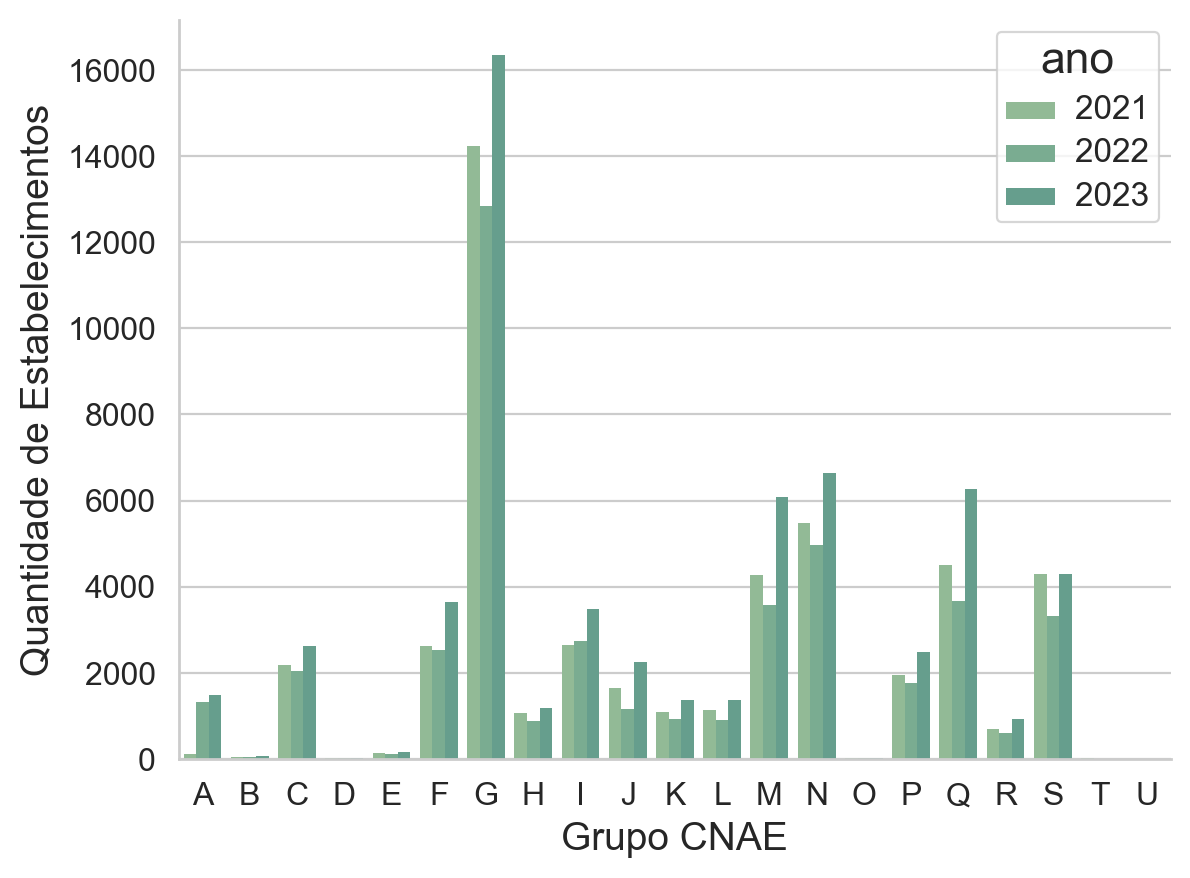

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper")

ax = sns.barplot(
    data=rais.groupby(['grupo_cnae', 'ano'], as_index=False).size().astype({'ano': 'str'}),
    x='grupo_cnae',
    y='size',
    hue='ano',
    linewidth=0,
    palette=sns.color_palette("crest", n_colors=len(range(2014, 2024))),
    )

plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set_xlabel("Grupo CNAE", fontsize=14)
ax.set_ylabel("Quantidade de Estabelecimentos", fontsize=14)
ax.tick_params(labelsize='large')

sns.despine()

plt.show()

In [109]:
rais.sample(5000).explore(prefer_canvas=True)

In [114]:
rais.head(3)

,cep,centroide,geometry,ano,id_municipio,tipo_estabelecimento,indicador_atividade_ano,quantidade_vinculos_ativos,natureza_juridica,cnae_2,grupo_cnae
0,24040280,POINT(-43.1246107417546 -22.8781466513866),POINT (-43.12461 -22.87815),2021,3303302,1,1,20,2062,10996,C
1,24040280,POINT(-43.1246107417546 -22.8781466513866),POINT (-43.12461 -22.87815),2021,3303302,1,1,2,2305,25322,C
2,24040280,POINT(-43.1246107417546 -22.8781466513866),POINT (-43.12461 -22.87815),2021,3303302,1,1,15,2062,27406,C


In [126]:
# Filter RAIS data for the year 2023
rais_2023 = rais.loc[rais['ano'] == 2023]

# Define the output path
output_dir = pathlib.Path('../database/1. Socioeconômicos')
output_path = output_dir / 'rais_2023.parquet'

# Ensure the parent directory exists
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save the data to a Parquet file with Brotli compression
rais_2023.to_parquet(output_path, index=False, compression='brotli')

In [127]:
# Consolidate rais_2023 by counting rows grouped by 'cep' and summing 'quantidade_vinculos_ativos'
rais_by_cep_2023 = (
    rais_2023
    .groupby('cep', as_index=False)
    .agg(
        quantidade_estabelecimentos=('cep', 'size'),
        quantidade_vinculos_ativos=('quantidade_vinculos_ativos', 'sum')
    )
)

# Merge with 'ceps' to retain geometries
rais_by_cep_2023 = (
    ceps
    .merge(rais_by_cep_2023, on='cep', how='inner')
    .drop(columns='centroide')
)


In [128]:
# Define the output path
output_path_cep = output_dir / 'rais_by_cep_2023.parquet'

# Save the consolidated data to a Parquet file with Brotli compression
rais_by_cep_2023.to_parquet(output_path_cep, index=False, compression='brotli')

In [129]:
rais_by_cep_2023.sum(numeric_only=True)

quantidade_estabelecimentos     56823
quantidade_vinculos_ativos     252761
dtype: int64

# Exercício

**Objetivo:** Compreender os fundamentos da análise de padrões de pontos (*Point Pattern Analysis*) e explorar técnicas para visualizar e interpretar eventos espaciais representados como pontos georreferenciados.

Abaixo, está um mapa com uma amostra ds emprgos da RAIS, representados por pontos que são a localização geogr;afica dos respectivos CEPs. 

Pontos no espaço podem representar fenômenos distintos dependendo de como os interpretamos. No caso da RAIS, ao geolocalizarmos estabelecimentos com base em seus CEPs, podemos tratá-los como **eventos que poderiam ocorrer em qualquer lugar da cidade, mas que se concentram em alguns pontos específicos**. Nesse contexto, nos interessa entender *por que* esses eventos (estabelecimentos) ocorrem em certas áreas e *como* estão distribuídos espacialmente.

Esse tipo de análise — conhecida como **padrão de pontos** — busca descrever e modelar a distribuição dos eventos no espaço. A distribuição pode ser:
- **Aleatória**, sem nenhuma estrutura evidente;
- **Agrupada**, sugerindo concentração em certas regiões;
- Ou **dispersa**, indicando distanciamento entre eventos.

A análise nos permite transformar listas de coordenadas em **fenômenos espaciais interpretáveis**, ajudando a responder perguntas como:
- Onde estão os centros de atividade econômica?
- Existem “vazios” no espaço urbano sem estabelecimentos?
- Há evidência de *clusters* (aglomerados) por setor ou tipo de empresa?

Trabalhe com os dados geolocalizados da RAIS, tratando cada ponto como uma observação de um processo espacial subjacente. A proposta é aplicar conceitos e ferramentas de análise de padrões pontuais para caracterizar a estrutura espacial dos dados — usando bibliotecas como `geopandas`, `pointpats` e `PySAL`.

Acompanhe o capítulo Point Pattern Analysis do livro [Geographic Data Science with Python](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html) e reproduza o exercício prático lá contido com os municípios acima. Documente o passo a passo e discuta e analise seus achados.

→ Note que exportamos dados de três anos (2021, 2022 e 2023). Extraia 2023 e faça as análises com esse subconjunto.
→ Você pode trabalhar com os dados agregados, mas pode ser interessante ver como a análise muda para as diferentes categorias do CONCLA.